LLMs, or Large Language Models, are the key component behind text generation. In a nutshell, they consist of large pretrained transformer models trained to predict the next word (or, more precisely, token) given some input text. Since they predict one token at a time, you need to do something more elaborate to generate new sentences other than just calling the model — you need to do autoregressive generation.

Autoregressive generation is the inference-time procedure of iteratively calling a model with its own generated outputs, given a few initial inputs. In 🤗 Transformers, this is handled by the generate() method, which is available to all models with generative capabilities.

This tutorial will show you how to:

Generate text with an LLM
Avoid common pitfalls
Next steps to help you get the most out of your LLM

Before you begin, make sure you have all the necessary libraries installed:

In [1]:
!pip install transformers bitsandbytes>=0.39.0 -q

 Generate text

A language model trained for causal language modeling takes a sequence of text tokens as input and returns the probability distribution for the next token.

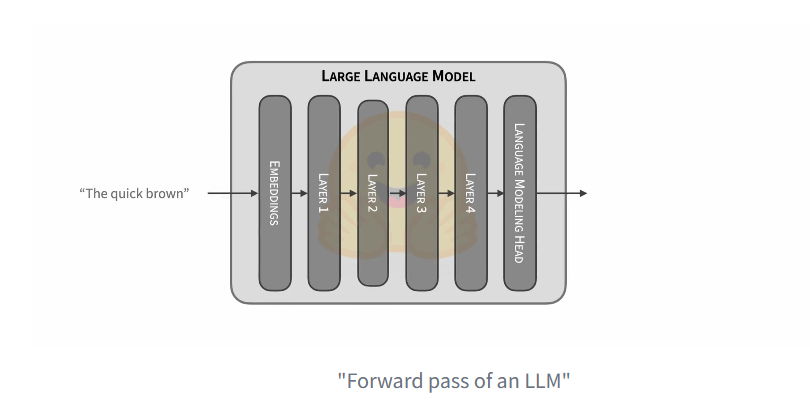

A critical aspect of autoregressive generation with LLMs is how to select the next token from this probability distribution. Anything goes in this step as long as you end up with a token for the next iteration. This means it can be as simple as selecting the most likely token from the probability distribution or as complex as applying a dozen transformations before sampling from the resulting distribution.

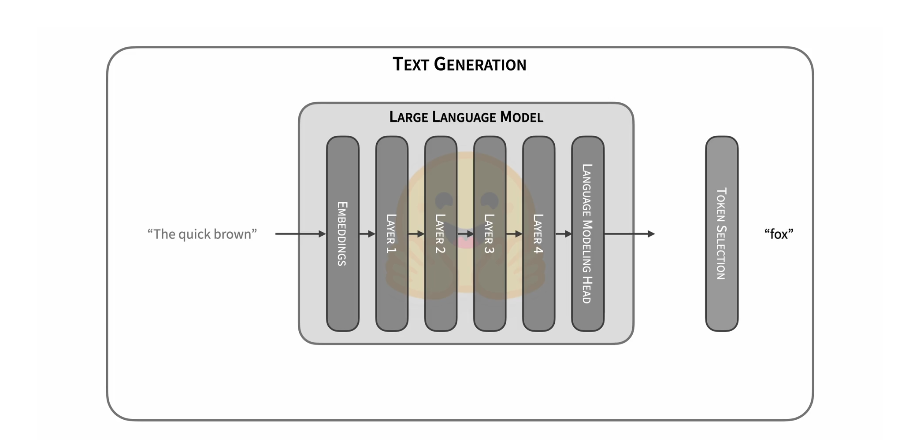

The process depicted above is repeated iteratively until some stopping condition is reached. Ideally, the stopping condition is dictated by the model, which should learn when to output an end-of-sequence (EOS) token. If this is not the case, generation stops when some predefined maximum length is reached.

Properly setting up the token selection step and the stopping condition is essential to make your model behave as you’d expect on your task. That is why we have a GenerationConfig file associated with each model, which contains a good default generative parameterization and is loaded alongside your model.

Let’s talk code!

If you’re interested in basic LLM usage, our high-level Pipeline interface is a great starting point. However, LLMs often require advanced features like quantization and fine control of the token selection step, which is best done through generate(). Autoregressive generation with LLMs is also resource-intensive and should be executed on a GPU for adequate throughput.

In [2]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.5 MB/s eta 0:00:00


In [3]:
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.7 MB/s eta 0:00:00


In [1]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.1", device_map="auto", load_in_4bit=True
)

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

You’ll notice two flags in the from_pretrained call:

device_map ensures the model is moved to your GPU(s)
load_in_4bit applies 4-bit dynamic quantization to massively reduce the resource requirements

There are other ways to initialize a model, but this is a good baseline to begin with an LLM.

Next, you need to preprocess your text input with a tokenizer.

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1", padding_side="left")
model_inputs = tokenizer(["A list of colors: red, blue"], return_tensors="pt").to("cuda")

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

The model_inputs variable holds the tokenized text input, as well as the attention mask. While generate() does its best effort to infer the attention mask when it is not passed, we recommend passing it whenever possible for optimal results.

After tokenizing the inputs, you can call the generate() method to returns the generated tokens. The generated tokens then should be converted to text before printing.

In [3]:
generated_ids = model.generate(**model_inputs)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')


'A list of colors: red, blue, green, yellow, orange, purple, pink,'

Finally, you don’t need to do it one sequence at a time! You can batch your inputs, which will greatly improve the throughput at a small latency and memory cost. All you need to do is to make sure you pad your inputs properly (more on that below).

In [4]:
tokenizer.pad_token = tokenizer.eos_token  # Most LLMs don't have a pad token by default
model_inputs = tokenizer(
    ["A list of colors: red, blue", "Portugal is"], return_tensors="pt", padding=True
).to("cuda")
generated_ids = model.generate(**model_inputs)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['A list of colors: red, blue, green, yellow, orange, purple, pink,',
 'Portugal is a country in southwestern Europe, on the Iber']

And that’s it! In a few lines of code, you can harness the power of an LLM.
Common pitfalls

There are many generation strategies, and sometimes the default values may not be appropriate for your use case. If your outputs aren’t aligned with what you’re expecting, we’ve created a list of the most common pitfalls and how to avoid them.

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
tokenizer.pad_token = tokenizer.eos_token  # Most LLMs don't have a pad token by default
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.1", device_map="auto", load_in_4bit=True
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Further resources

While the autoregressive generation process is relatively straightforward, making the most out of your LLM can be a challenging endeavor because there are many moving parts. For your next steps to help you dive deeper into LLM usage and understanding:
Advanced generate usage

Guide on how to control different generation methods, how to set up the generation configuration file, and how to stream the output;
https://huggingface.co/docs/transformers/generation_strategies

Guide on the prompt template for chat LLMs;
https://huggingface.co/docs/transformers/chat_templating

Guide on to get the most of prompt design;
https://huggingface.co/docs/transformers/tasks/prompting
  
API reference on GenerationConfig, generate(), and generate-related classes. Most of the classes, including the logits processors, have usage examples!
https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/text_generation#transformers.GenerationConfig
https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/text_generation#transformers.GenerationMixin.generate
https://huggingface.co/docs/transformers/internal/generation_utils

LLM leaderboards

Open LLM Leaderboard, which focuses on the quality of the open-source models;
https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard

Open LLM-Perf Leaderboard, which focuses on LLM throughput.
https://huggingface.co/docs/transformers/main_classes/quantization

Latency, throughput and memory utilization

Guide on how to optimize LLMs for speed and memory;
https://huggingface.co/docs/transformers/llm_tutorial_optimization

Guide on quantization such as bitsandbytes and autogptq, which shows you how to drastically reduce your memory requirements.
https://huggingface.co/docs/transformers/main_classes/quantization

Related libraries

text-generation-inference, a production-ready server for LLMs;
https://github.com/huggingface/text-generation-inference

optimum, an extension of 🤗 Transformers that optimizes for specific hardware devices.
https://github.com/huggingface/optimum